## Four-Stock Portfolio Optimization Problem

Let us consider a portfolio optimization problem where you have a total of four assets (e.g. STOCK0, STOCK1, STOCK2, STOCK3) to choose from. Your goal is to find out a combination of two assets that will minimize the tradeoff between risk and return which is the same as finding the efficient frontier for the given risk. 

In [8]:
#Let us begin by importing necessary libraries.
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)

## Generate time series data (Financial Data)

In [2]:
# Set parameters for assets and risk factor
num_assets = 4     # set number of assets to 4
q = 0.5                   # set risk factor to 0.5
budget = 2           # set budget as defined in the problem

# Generate time series data
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(1955,11,5),   
                 end=datetime.datetime(1985,10,26))
data.run()

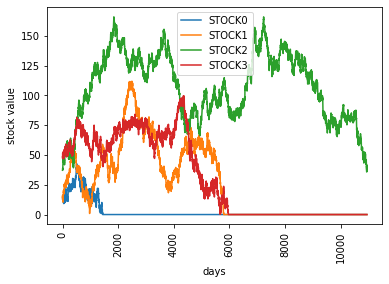

In [3]:
# Let's plot our finanical data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

## Quadratic Program Formulation

Let's generate the expected return first and then the covariance matrix which are both needed to create our portfolio.

In [4]:
#Let's calculate the expected return for our problem data

mu = data.get_period_return_mean_vector()   # Returns a vector containing the mean value of each asset's expected return.

print(mu)

[6.21131738e-04 5.05237700e-05 6.54491183e-05 4.20142920e-04]


### Covariance Matrix Σ

[[ 3.83590232e-03 -2.33828184e-05 -1.14239392e-06  1.51135056e-05]
 [-2.33828184e-05  1.13995459e-03  4.48885666e-06 -2.27233223e-05]
 [-1.14239392e-06  4.48885666e-06  1.13074147e-04  6.31506196e-06]
 [ 1.51135056e-05 -2.27233223e-05  6.31506196e-06  2.38520104e-03]]


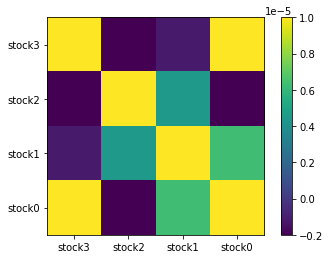

In [5]:
# Let's plot our covariance matrix Σ（sigma）
sigma = data.get_period_return_covariance_matrix() #Returns the covariance matrix of the four assets
print(sigma)
fig, ax = plt.subplots(1,1)
im = plt.imshow(sigma, extent=[-1,1,-1,1])
x_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
y_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
ax.set_xticks([-0.75,-0.25,0.25,0.75])
ax.set_yticks([0.75,0.25,-0.25,-0.75])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.colorbar()
plt.clim(-0.000002, 0.00001)
plt.show()

Now that we have all the values we need to build our portfolio for optimization, we will look into Qiskit's Finance application class that will help us contruct the quadratic program for our problem.

## Portfolio instance using PortfolioOptimization class


In [12]:
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()

print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000621131738 x_0 - 0.000050523770 x_1 - 0.000065449118 x_2
      - 0.000420142920 x_3 + [ 0.003835902317 x_0^2 - 0.000046765637 x_0*x_1
      - 0.000002284788 x_0*x_2 + 0.000030227011 x_0*x_3 + 0.001139954591 x_1^2
      + 0.000008977713 x_1*x_2 - 0.000045446645 x_1*x_3 + 0.000113074147 x_2^2
      + 0.000012630124 x_2*x_3 + 0.002385201038 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End




Lets solve the problem. First classically...


In [14]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)

optimal function value: 0.0005150303373461622
optimal value: [0. 1. 1. 0.]
status: SUCCESS


## Solution using VQE

**Variational Quantum Eigensolver (VQE)** is a classical-quantum hybrid algorithm which outsources some of the processing workload to a classical computer to efficiently calculate the ground state energy (lowest energy) of a [**Hamiltonian**](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)).

In [16]:
optimizer = SLSQP(maxiter=1000)  
backend = Aer.get_backend('statevector_simulator')

vqe = VQE(optimizer= optimizer, quantum_instance= backend)

vqe_meo = MinimumEigenOptimizer(vqe)  

result = vqe_meo.solve(qp) 

print(result) 

optimal function value: 0.0005150303373461622
optimal value: [0. 1. 1. 0.]
status: SUCCESS


Solutionusing QAOA

**Quantum Approximate Optimization Algorithm (QAOA)** is another variational algorithm that has applications for solving combinatorial optimization problems on near-term quantum systems.


In [20]:
optimizer1 = SLSQP(maxiter=1000)  
backend1 = Aer.get_backend('statevector_simulator')

qaoa = QAOA(optimizer= optimizer, quantum_instance= backend)

qaoa_meo = MinimumEigenOptimizer(qaoa) 

result2 = qaoa_meo.solve(qp)

print(result2) 

optimal function value: 0.0005150303373461622
optimal value: [0. 1. 1. 0.]
status: SUCCESS
